In [48]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from transformers import AdamW, get_scheduler

from jre_utils.datapath import (
    processed_pretraining_data_paths,
    pretraining_data_paths,
    pretrained_weights_paths,
)
from jre_utils.data import TimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.engine import (
    evaluate,
    train,
    EarlyStopper,
)
from jre_utils.metrics import MSELossWeighted

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [49]:
dataset = "exchange_rate"
df = pd.read_csv(pretraining_data_paths[dataset])
date_time = pd.to_datetime(df.pop("date"), format='%Y/%m/%d %H:%M')

In [50]:
df.head()

,0,1,2,3,4,5,6,OT
0,0.7855,1.6110,0.861698,0.634196,0.211242,0.006838,0.525486,0.5930
1,0.7818,1.6100,0.861104,0.633513,0.211242,0.006863,0.523972,0.5940
2,0.7867,1.6293,0.861030,0.648508,0.211242,0.006975,0.526316,0.5973
3,0.7860,1.6370,0.862069,0.650618,0.211242,0.006953,0.523834,0.5970
4,0.7849,1.6530,0.861995,0.656254,0.211242,0.006940,0.527426,0.5985


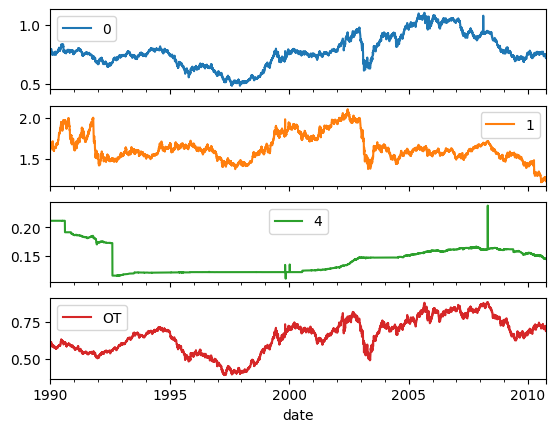

In [51]:
plot_cols = ['0', '1', '4', 'OT']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,7588.0,0.776974,0.136620,0.483297,0.701422,0.761377,0.873477,1.102536
1,7588.0,1.634105,0.161544,1.211534,1.532887,1.606574,1.707646,2.109000
2,7588.0,0.821811,0.117123,0.618582,0.727901,0.811582,0.920394,1.091524
3,7588.0,0.848146,0.168874,0.548617,0.696864,0.813959,1.014018,1.374079
4,7588.0,0.142833,0.023996,0.109292,0.120814,0.145212,0.159948,0.237954
5,7588.0,0.009343,0.001458,0.006254,0.008331,0.009151,0.009995,0.013202
6,7588.0,0.669673,0.082836,0.523834,0.593287,0.662767,0.731835,0.832556
OT,7588.0,0.654418,0.115292,0.393153,0.566000,0.669187,0.734901,0.882379


In [6]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.9)]
val_df = df[int(n*0.9):]

num_features = df.shape[1]

In [7]:
# train_mean = train_df.mean()
# train_std = train_df.std()

# train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std

In [8]:
train_df

,0,1,2,3,4,5,6,OT
0,0.785500,1.611000,0.861698,0.634196,0.211242,0.006838,0.525486,0.593000
1,0.781800,1.610000,0.861104,0.633513,0.211242,0.006863,0.523972,0.594000
2,0.786700,1.629300,0.861030,0.648508,0.211242,0.006975,0.526316,0.597300
3,0.786000,1.637000,0.862069,0.650618,0.211242,0.006953,0.523834,0.597000
4,0.784900,1.653000,0.861995,0.656254,0.211242,0.006940,0.527426,0.598500
...,...,...,...,...,...,...,...,...
6824,0.853424,1.578432,0.889787,1.040242,0.162890,0.008502,0.770214,0.788022
6825,0.854555,1.571709,0.881418,1.038044,0.162890,0.008489,0.769734,0.786565
6826,0.852479,1.563551,0.875603,1.035368,0.162782,0.008425,0.766912,0.784037
6827,0.850738,1.565398,0.875833,1.036216,0.162782,0.008429,0.766762,0.784314


In [9]:
train_df.to_csv(processed_pretraining_data_paths[dataset]["train"], index=False)
val_df.to_csv(processed_pretraining_data_paths[dataset]["eval"], index=False)

In [10]:
# df_std = (df - train_mean) / train_std
# df_std = df_std.melt(var_name='Column', value_name='Normalized')
# plt.figure(figsize=(12, 6))
# ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
# _ = ax.set_xticklabels(df.keys(), rotation=90)

In [39]:
BATCH_SIZE = 64
window_length = 50
shift = 10

feature_columns = df.columns
# feature_columns = ["OT"]

train_dataset = TimeSeriesDataset(
    train_df,
    metrics=feature_columns,
    feature_columns=feature_columns,
    window_length=window_length,
    shift=shift,
    transform=transforms.Compose(
        [ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]
    ),
)
val_dataset = TimeSeriesDataset(
    val_df,
    metrics=["OT"],
    feature_columns=feature_columns,
    window_length=window_length,
    shift=shift,
    transform=transforms.Compose(
        [ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]
    ),
)

In [40]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
eval_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [41]:
for i, sample in enumerate(train_dataloader):
    if i == 0:
        print(i, sample["window"].shape, sample["target"].shape)
        break

0 torch.Size([64, 50, 8]) torch.Size([64, 1])


In [42]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [43]:
n_features = len(feature_columns)
d_model = 128
d_hid = 256
nlayers = 4
nhead = 4
dropout = 0.1
enc_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    device=device,
)
model = model.to(device)


In [44]:
model.eval()
mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)
        print("Loss:", loss.item())

        if i == 0:
            break

torch.Size([64, 50, 8]) torch.Size([64, 50]) torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1])
Loss: 0.4085959792137146


In [45]:
learning_rate = 1e-4
num_epochs = 20

In [46]:
train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [47]:
num_training_steps = num_epochs * len(train_dataloader)

optimizer = AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))
early_stopper = EarlyStopper(patience=5, min_delta=0.01)

for epoch in range(num_epochs):
    train_loss, train_r2_score = train(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)

    if early_stopper.early_stop(eval_loss):
        print(f"Early stopping at epoch {epoch}")
        break


progress_bar.close()

 60%|██████    | 1284/2140 [01:53<01:15, 11.34it/s]

Early stopping at epoch 11


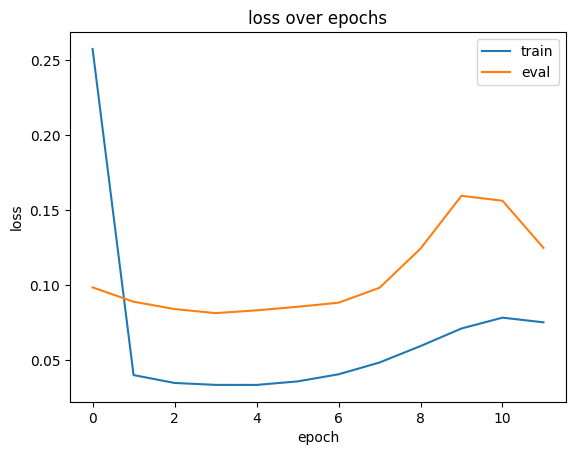

In [37]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

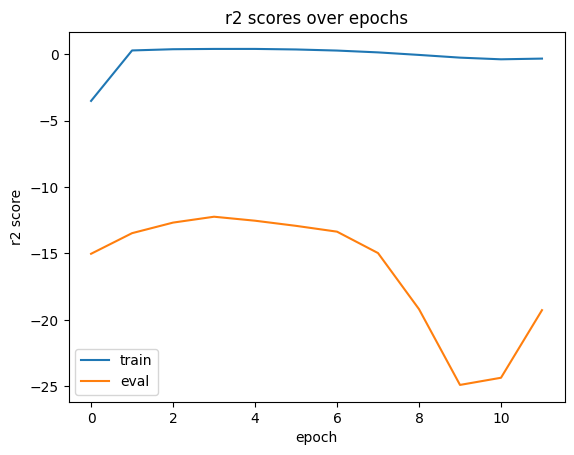

In [38]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()